<a href="https://colab.research.google.com/github/paidahui/machine-learning-curriculum-design/blob/main/Traffic_state_spatio_temporal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

首先用pip安装catboost

In [ ]:
!pip install catboost -i  https://pypi.doubanio.com/simple/

Looking in indexes: https://pypi.doubanio.com/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 23 kB/s 


统一导入需要使用的包

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from scipy.stats import stats
import warnings
warnings.filterwarnings("ignore")

DEBUG参数为True时可快速跑通代码，为False则恢复为真实案例

In [ ]:
NROWS=None
MAX_DEPTH=8
K_FOLD=10

In [ ]:
data = pd.read_csv(r'./drive/MyDrive/datasets/data/20190701.csv',nrows=1)
data

,link,label,current_slice_id,future_slice_id,time_of_r_f_1,speed_of_r_f_1,eta_speed_of_r_f_1,statu_of_r_f_1,num_car_of_r_f_1,time_of_r_f_2,...,time_of_h_f_4_4,speed_of_h_f_4_4,eta_speed_of_h_f_4_4,statu_of_h_f_4_4,num_car_of_h_f_4_4,time_of_h_f_4_5,speed_of_h_f_4_5,eta_speed_of_h_f_4_5,statu_of_h_f_4_5,num_car_of_h_f_4_5
0,353495,1,236,245,232,29.8,32.4,1,4,233,...,248,30.0,35.6,1,4,249,29.4,37.2,1,5


In [ ]:
data = pd.read_table(r'./drive/MyDrive/datasets/data/20190701.txt',header=None,sep=';',nrows=1)
data

,0,1,2,3,4,5
0,353495 1 236 245,"232:29.80,32.40,1,4 233:31.60,32.20,1,2 234:20...","245:30.00,32.70,0,9 246:30.00,36.10,0,10 247:2...","245:36.10,37.30,1,7 246:29.30,38.50,1,7 247:27...","245:30.40,40.10,1,6 246:32.30,40.10,1,6 247:30...","245:28.30,38.40,1,7 246:28.20,39.40,1,6 247:28..."


In [ ]:
data[1]

0    232:29.80,32.40,1,4 233:31.60,32.20,1,2 234:20...
Name: 1, dtype: object

读取数据，将所有日期整合到一起

100%|██████████| 21/21 [00:41<00:00,  1.98s/it]


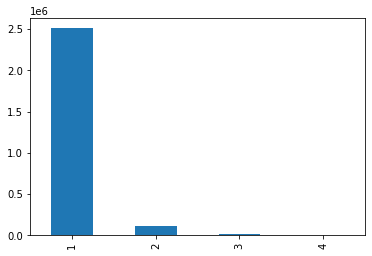

In [ ]:
data = pd.DataFrame()
dates=['20190710',
       '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719','20190720',
      '20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730',]

for date in tqdm(dates):
    tmp = pd.read_csv(r'./drive/MyDrive/datasets/data/all_{}.csv'.format(date),nrows=NROWS)
    tmp=tmp[tmp['day']>0]
    tmp=tmp[tmp['statu_of_r_f']!=0]
    tmp=tmp[tmp['statu_of_r_f']!=-1]
    data = pd.concat([data,tmp],axis = 0)
    #去重
    data =data.drop_duplicates(['link','day','time_of_r_f','speed_of_r_f','eta_speed_of_r_f','statu_of_r_f','num_car_of_r_f','hour','minute'])
    
    
data['time'] = pd.to_datetime(data['time'], infer_datetime_format=True)
data=data.sort_values(by=['time'],ascending=True)
data['statu_of_r_f'].value_counts().plot.bar()

100%|██████████| 21/21 [01:32<00:00,  4.40s/it]


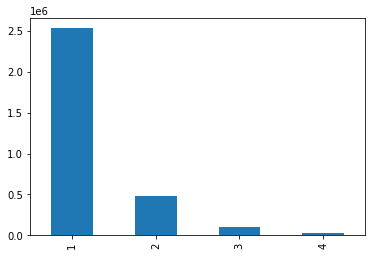

In [ ]:
dates=['20190710',
       '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719','20190720',
      '20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730',]

train = pd.DataFrame()
count = 10
for date in tqdm(dates):
    tmp = pd.read_csv(r'./drive/MyDrive/datasets/data/{}.csv'.format(date),nrows=NROWS)


    tmp['day']=count
    count =count+1
    train = pd.concat([train,tmp],axis = 0)

train['label'].value_counts().plot.bar()

查看数据集中的时间分布,btest.csv文件是为了方便提取特征将测试集时间片并列排列的数据，结构同data

In [ ]:
testdata = pd.read_csv(r'./drive/MyDrive/datasets/data/btest.csv')

测试集

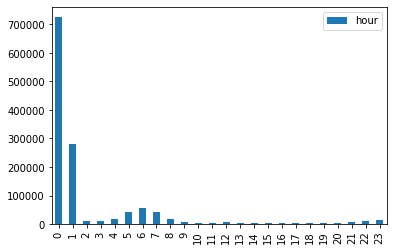

In [ ]:
test_hour = testdata.hour.value_counts().reset_index().sort_values(by=['index'],ascending=True).reset_index(drop=True)
test_hour.drop('index',axis=1).plot.bar()

训练集

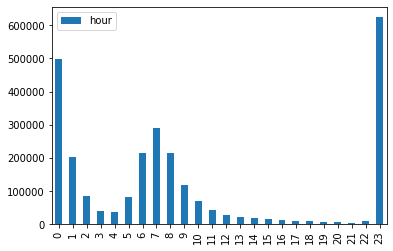

In [ ]:
data = data.hour.value_counts().reset_index().sort_values(by=['index'],ascending=True).reset_index(drop=True)
data.drop('index',axis=1).plot.bar()

In [ ]:
testdata=testdata[testdata['day']==1]
#合并两个用于提取特征的数据集
data = pd.concat([data,testdata],axis = 0)
data['time'] = pd.to_datetime(data['time'], infer_datetime_format=True)
data=data.sort_values(by=['time'],ascending=True).reset_index(drop=True)
#读取测试集、道路拓扑信息和道路基本物理信息
testa=pd.read_csv(r'./drive/MyDrive/datasets/data/20190801_testdata.csv',nrows=NROWS)
topo = pd.read_csv(r'./drive/MyDrive/datasets/data/topo.txt', sep='\t', names=['link', 'roundlink'], header=None)
attr = pd.read_table(r'./drive/MyDrive/datasets/data/attr.txt',header=None)
attr.columns = ['link','length','direction','pathclass','speedclass','LaneNum','speedlimit','level',
                    'width']
#获取当前与预测时间的差距
testa['timestamp'] = testa['future_slice_id'] - testa['current_slice_id']
train['timestamp'] = train['future_slice_id'] - train['current_slice_id']
train['hour']=train['future_slice_id']  //30
testa['hour']=testa['future_slice_id']  //30

选出训练集中和测试集每个link时间分布一样的数据，即采样。

In [ ]:
havelink = testa['link'].unique()
for i in tqdm(havelink):
    time = testa[testa['link']==i]['hour'].value_counts().index
    train.loc[((train['link'] == i) & (train['hour'].isin(time ))) ,'isok'] =  1

train=train[train['isok']==1]

100%|██████████| 12224/12224 [11:42<00:00, 17.39it/s]


观察当前与预测时间的差距

In [ ]:
print("差距的中位数:{}".format(train['timestamp'].median()))
print("差距的平均数:{}".format(train['timestamp'].mean()))
#观察其他性质
print("平均速度：{}".format(data['speed_of_r_f'].mean()))
print("link的平均长度:{}".format(attr['length'].mean()))

差距的中位数:16.0
差距的平均数:15.518925972170665
平均速度：5.702746862323932
link的平均长度:104.681886883203


合并数据集

In [ ]:
train = pd.concat([train,testa])

In [ ]:
#该函数用于统计标签的频率、通常范围,速度、车辆数的统计值等
def get_feat1(y,feat,feat1,linkdata):

    b=linkdata[(linkdata['time_of_r_f']<y)& (linkdata['time_of_r_f']>=y-10)]
    #如果是状态，那么统计状态相关信息
    if feat1 =='statu_of_r_f':
        if feat =='mean':
            #均值
            return  np.mean(b['statu_of_r_f'])
        elif feat =='max':
            #label大于3的比例（为防止分母出现0，所以分母加1）
            return  len(b[b['statu_of_r_f']>=3]) /  (len(b)+1)
        elif feat =='std':
            #方差
            return  np.std((b['statu_of_r_f']))
        else:
            return  len(b[b['statu_of_r_f']==2])/ (len(b)+1)
    #如果不是状态，而是如车辆数等的一些信息，那么提取一些统计值
    else:
        if len(b)>0:
            if feat =='mean':
                 #均值
                return  np.mean(b[feat1])
            elif feat =='max':
                 #最大
                return  max(b[feat1])
            elif feat =='std':
                 #方差
                return  np.std(b[feat1])
            else:
                #最小
                return  min(b[feat1])
        else:
            return -1

In [ ]:
testdatafeat1= pd.DataFrame()
#每条link一一追溯
for i in tqdm(havelink):
    tmptest = train[train['link']==i]
    
    linktip= pd.DataFrame(columns = ["otherlink"])
    linktip=linktip.append(pd.DataFrame({"otherlink":i},index = [0]))
    if len(topo[topo['link']==i]['roundlink'] )>0:
        roundlink = str(topo[topo['link']==i]['roundlink'].values[0]).split(',')
        roundlink = list(map(int, roundlink))
    linktip=linktip.append(pd.DataFrame({"otherlink":roundlink}))
    count =1
    #添加拓扑相邻的link
    
    for count in range(1,3):
      lastlink=roundlink
      roundlink=[]
      #记录下一阶的link
      for k in lastlink:
          if len(topo[topo['link']==k]['roundlink'] )>0:
              roundlink=roundlink+list(map(int, str(topo[topo['link']==k]['roundlink'].values[0]).split(',')))
      #已经记录的link

      alllink = list(linktip['otherlink'].unique())
      linkall = alllink + roundlink
      linkall=set(linkall)
      linkall=list(linkall)
      #不包含在已经记录的link里面的
      roundlink = list(set(linkall)^set(alllink))
      linkdata = data[data['link'].isin(roundlink)]
      linktip=linktip.append(pd.DataFrame({"otherlink":roundlink}))
      for feat in ['mean','max']:
          for feat1 in ['statu_of_r_f','speed_of_r_f','num_car_of_r_f']:
              tmptest['{}_{}_{}'.format(count,feat,feat1)]=list(map(lambda y:  get_feat1(y,feat,feat1,linkdata) if str(y)!='nan'   else 0 ,tmptest['current_slice_id']))
              train.loc[((train['link'] == i)),'{}_{}_{}'.format(count,feat,feat1)] =  tmptest['{}_{}_{}'.format(count,feat,feat1)].values

100%|██████████| 12224/12224 [1:21:56<00:00,  2.49it/s]


In [ ]:
def get_feature(train):
    #对近期时间片和历史同期时间片进行统计
    for feat in tqdm(['speed','eta_speed','statu','num_car',]):
        train['mean_1_5_rf_{}'.format(feat)]=(train['{}_of_r_f_1'.format(feat)] +train['{}_of_r_f_2'.format(feat)]+train['{}_of_r_f_3'.format(feat)]+train['{}_of_r_f_4'.format(feat)]+train['{}_of_r_f_5'.format(feat)])/5
        train['mean_1_5_rf_{}'.format(feat)]=(train['{}_of_r_f_1'.format(feat)] +train['{}_of_r_f_2'.format(feat)]+train['{}_of_r_f_3'.format(feat)]+train['{}_of_r_f_4'.format(feat)]+train['{}_of_r_f_5'.format(feat)])/5
        train['max_1_5_rf_{}'.format(feat)]=list(map(lambda x,y,z,h,n:   max([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_r_f_1'.format(feat)],train['{}_of_r_f_2'.format(feat)],train['{}_of_r_f_3'.format(feat)],train['{}_of_r_f_4'.format(feat)],train['{}_of_r_f_5'.format(feat)]))
        train['min_1_5_rf_{}'.format(feat)]=list(map(lambda x,y,z,h,n:   min([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_r_f_1'.format(feat)],train['{}_of_r_f_2'.format(feat)],train['{}_of_r_f_3'.format(feat)],train['{}_of_r_f_4'.format(feat)],train['{}_of_r_f_5'.format(feat)]))
        train['std_1_5_rf_{}'.format(feat)]=list(map(lambda x,y,z,h,n:   np.std([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_r_f_1'.format(feat)],train['{}_of_r_f_2'.format(feat)],train['{}_of_r_f_3'.format(feat)],train['{}_of_r_f_4'.format(feat)],train['{}_of_r_f_5'.format(feat)]))
        train['median_1_5_rf_{}'.format(feat)]=list(map(lambda x,y,z,h,n:   np.median([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_r_f_1'.format(feat)],train['{}_of_r_f_2'.format(feat)],train['{}_of_r_f_3'.format(feat)],train['{}_of_r_f_4'.format(feat)],train['{}_of_r_f_5'.format(feat)]))

        for  i in range(1,5):
            train['mean_1_5_hf_{}_{}'.format(feat,i)]=list(map(lambda x,y,z,h,n:   np.mean([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_h_f_{}_1'.format(feat,i)],train['{}_of_h_f_{}_2'.format(feat,i)],train['{}_of_h_f_{}_3'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)]))
            train['max_1_5_hf_{}_{}'.format(feat,i)]=list(map(lambda x,y,z,h,n:   max([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_h_f_{}_1'.format(feat,i)],train['{}_of_h_f_{}_2'.format(feat,i)],train['{}_of_h_f_{}_3'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)]))
            train['min_1_5_hf_{}_{}'.format(feat,i)]=list(map(lambda x,y,z,h,n:   min([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_h_f_{}_1'.format(feat,i)],train['{}_of_h_f_{}_2'.format(feat,i)],train['{}_of_h_f_{}_3'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)]))
            train['std_1_5_hf_{}_{}'.format(feat,i)]=list(map(lambda x,y,z,h,n:   np.std([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_h_f_{}_1'.format(feat,i)],train['{}_of_h_f_{}_2'.format(feat,i)],train['{}_of_h_f_{}_3'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)]))
            train['median_1_5_hf_{}_{}'.format(feat,i)]=list(map(lambda x,y,z,h,n:   np.median([x,y,z,h,n])  if str(x)!='nan'   else 0 ,train['{}_of_h_f_{}_1'.format(feat,i)],train['{}_of_h_f_{}_2'.format(feat,i)],train['{}_of_h_f_{}_3'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)],train['{}_of_h_f_{}_4'.format(feat,i)]))
    return train
train=get_feature(train)
#连接道路物理特征
train = train.merge(attr, on='link', how='left')

100%|██████████| 4/4 [09:58<00:00, 149.64s/it]


In [ ]:
#标注出不参与训练的特征
underfeat= ['time_of_h_f_1_1',
       'time_of_h_f_1_2', 'time_of_h_f_1_3', 'time_of_h_f_1_4',
       'time_of_h_f_1_5', 'time_of_h_f_2_1', 'time_of_h_f_2_2',
       'time_of_h_f_2_3', 'time_of_h_f_2_4', 'time_of_h_f_2_5',
       'time_of_h_f_3_1', 'time_of_h_f_3_2', 'time_of_h_f_3_3',
       'time_of_h_f_3_4', 'time_of_h_f_3_5', 'time_of_h_f_4_1',
       'time_of_h_f_4_2', 'time_of_h_f_4_3', 'time_of_h_f_4_4',
       'time_of_h_f_4_5', 'time_of_r_f_1', 'time_of_r_f_2', 'time_of_r_f_3',
       'time_of_r_f_4', 'time_of_r_f_5', 'day','label']
#获取训练特征
feature = train.columns.difference(underfeat)
#划分训练集和验证集
traindata = train[train['day']>=11]
traindata.reset_index(inplace=True,drop=True)
valid= train[(train['day']<=10) & (train['day']>=9) ]
train['day']=train['day'].fillna(1)
traindata['label'] = traindata['label'].apply(lambda x:3 if x>=3 else x)
testa= train[train['day']==1 ]

In [ ]:
def get_model_type(train_x,train_y,valid_x,valid_y,m_type='lgb'):   
    if m_type == 'lgb':
        model = lgb.LGBMClassifier( num_leaves=2**6-1, reg_alpha=0.2, reg_lambda=0.2, objective='multiclass',
                                max_depth=MAX_DEPTH, learning_rate=0.01, min_sum_hessian_in_leaf=3, random_state=2020,
                                n_estimators=2500, colsample_bytree=0.75,metric= 'multi_error'
                                )
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              early_stopping_rounds=100, verbose=100)      
    elif m_type == 'xgb':
        params = {'booster': 'gbtree',
          'objective': 'multi:softmax', #多分类'multi:softmax'返回预测的类别(不是概率)，'multi:softprob'返回概率
          'num_class': 3,
          'eval_metric': 'merror', #二分类用’auc‘，多分类用'mlogloss'或'merror'
          'max_depth': MAX_DEPTH,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.01,
          'seed': 0,
          'nthread': 7,
          'silent': 1,
          'gamma': 0.01,
           'num_boost_round':400}
        model = XGBClassifier(**params)  
       
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              early_stopping_rounds=100, verbose=100)   
    
    elif m_type == 'cat':
        
        model = CatBoostClassifier(
            iterations=600,
            od_type='Iter',
            od_wait=100,
            max_depth=MAX_DEPTH,
            learning_rate=0.01,
            l2_leaf_reg=9,
            random_seed=1010,
            metric_period=50,
            fold_len_multiplier=1.1,
            loss_function='MultiClass',
            logging_level='Verbose'
            
            )
        cat_attrs=['link','timestamp']
        model.fit(train_x, train_y,cat_features=cat_attrs,
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              early_stopping_rounds=100, verbose=200)   

    return model

In [ ]:
def f1Score(A,B,average='weighted'):
    A.reset_index(drop=True,inplace=True)
    B.reset_index(drop=True,inplace=True)
    
    return f1_score(A,B,average='weighted')
def downmse(vali,yue):
    vali['A']=vali['label']
    vali['yue']=yue
    vali.loc[(vali['label'] >=3), 'label'] =  3
    vali.loc[(vali['yue'] >=3), 'label'] =  3
    vali.loc[(vali['label'] ==1), 'is_close'] =  -1
    vali.loc[(vali['label'] ==2), 'is_close'] =  0
    vali.loc[(vali['label']>=3), 'is_close'] =  1
    f1_1 = f1Score(vali[vali['is_close']==-1]['label'],vali[vali['is_close']==-1]['yue'],average='weighted')#验证集上的f1值
    f1_2 = f1Score(vali[vali['is_close']==0]['label'],vali[vali['is_close']==0]['yue'],average='weighted')#验证集上的f1值
    f1_3 = f1Score(vali[vali['is_close']==1]['label'],vali[vali['is_close']==1]['yue'],average='weighted')#验证集上的f1值
    print("验证集上标签为1的f1值：",f1_1)
    print("验证集上标签为2的f1值：",f1_2)
    print("验证集上标签为3的f1值：",f1_3)
    f1 = f1_1 *0.2 + f1_2*0.2 + f1_3*0.6
    print("验证集总分：",f1)
    vali['label']=vali['A']

In [ ]:
def train_start(traindata,valid,testa,feature,index_cols,m_type='xgb',average='weighted'):
    kf = KFold(n_splits=K_FOLD,shuffle=True,random_state=220)
    j = 0
    index_cols=['label']
    #score用来存储验证集预测结果
    #scoret用来存储预测结果
    score = pd.DataFrame()
    scoret = pd.DataFrame()
    #在处理后，每个样本已经独立，可以进行k折交叉验证
     #在处理后，每个样本已经独立，可以进行k折交叉验证
    for train_index , test_index in kf.split(traindata):
        print("************************"+m_type+":{}******************************".format(j+1))
        #v_train是本次训练的训练集
        #v_test是本次训练的测试集
        v_train =traindata.loc[train_index]
        v_test =traindata.loc[test_index]
        #通过关键字m_type调用相应模型
        model = get_model_type(v_train[feature],v_train[index_cols],v_test[feature],v_test[index_cols],m_type=m_type)
        #catboost模型的输出不太一样，需要单独处理
        #这里在交叉验证时，我们没有着急融合，而是将每一次的结果存储起来
        if m_type=='cat':
            yue = model.predict(valid[feature])  
            downmse(valid,yue)
            score['pre_{}'.format(j)] = pd.DataFrame(yue)[0]
            yue = model.predict(testa[feature]) 
            scoret['pre_{}'.format(j)] = pd.DataFrame(yue)[0]
        else:
            yue = model.predict(valid[feature])  
            downmse(valid,yue)
            score['pre_{}'.format(j)] = yue
            yue = model.predict(testa[feature]) 
            scoret['pre_{}'.format(j)] = yue

        j = j+1
    return scoret,score

In [ ]:
traindata.label.unique()

array([1, 3, 2])

In [ ]:
index_cols = ['label']
#调用xgboost
xgb_scoret,xgb_score = train_start(traindata,valid,testa,feature,index_cols,m_type='xgb',average='weighted')
#xgb验证集结果融合
xgb_score['predict']=xgb_score.max(axis=1)
#xgb线下验证
downmse(valid,xgb_score['predict'].values)

************************xgb:1******************************
[0]	validation_0-merror:0.039493	validation_1-merror:0.045624
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.014598	validation_1-merror:0.035944
验证集上标签为1的f1值： 0.9968787820880312
验证集上标签为2的f1值： 0.4739336492890995
验证集上标签为3的f1值： 0.5772357723577236
验证集总分： 0.6405039496900603
************************xgb:2******************************
[0]	validation_0-merror:0.039853	validation_1-merror:0.045683
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.014565	validation_1-merror:0.036593
验证集上标签为1的f1值： 0.9967526265520534
验证集上标签为2的f1值： 0.44878048780487806
验证集上标签为3的f1值： 0.5772357723577236
验证集总分： 0.6354480862860206
************************xgb:3**********************

In [ ]:
#调用catboost
cat_scoret,cat_score = train_start(traindata,valid,testa,feature,index_cols,m_type='cat',average='micro')
#验证集结果融合
cat_score['predict']=cat_score.max(axis=1)
#线下验证
downmse(valid,cat_score['predict'].values)

************************cat:1******************************


0:	learn: 1.0812012	test: 1.0812012	test1: 1.0811713	best: 1.0811713 (0)	total: 2.41s	remaining: 24m 1s
200:	learn: 0.2125638	test: 0.2125634	test1: 0.2109498	best: 0.2109498 (200)	total: 7m 18s	remaining: 14m 29s
400:	learn: 0.1352297	test: 0.1264822	test1: 0.1317394	best: 0.1317394 (400)	total: 14m 19s	remaining: 7m 6s
599:	learn: 0.1235403	test: 0.1094624	test1: 0.1198855	best: 0.1198855 (599)	total: 21m 24s	remaining: 0us

bestTest = 0.1198855318
bestIteration = 599

验证集上标签为1的f1值： 0.4986622499681488
验证集上标签为2的f1值： 0.26107226107226106
验证集上标签为3的f1值： 0.21733821733821734
验证集总分： 0.28234983261101243
************************cat:2******************************


0:	learn: 1.0811961	test: 1.0811961	test1: 1.0811568	best: 1.0811568 (0)	total: 2.35s	remaining: 23m 25s
200:	learn: 0.2121217	test: 0.2121205	test1: 0.2116101	best: 0.2116101 (200)	total: 7m 16s	remaining: 14m 25s
400:	learn: 0.1352448	test: 0.1277836	test1: 0.1329875	best: 0.1329875 (400)	total: 14m 20s	remaining: 7m 6s
599:	learn: 0.1235076	test: 0.1107324	test1: 0.1207268	best: 0.1207268 (599)	total: 21m 23s	remaining: 0us

bestTest = 0.1207268316
bestIteration = 599

验证集上标签为1的f1值： 0.49853465851172274
验证集上标签为2的f1值： 0.2587412587412587
验证集上标签为3的f1值： 0.21728395061728392
验证集总分： 0.28182555382096663
************************cat:3******************************


0:	learn: 1.0811907	test: 1.0811907	test1: 1.0812843	best: 1.0812843 (0)	total: 2.23s	remaining: 22m 19s
200:	learn: 0.2120202	test: 0.2120195	test1: 0.2148091	best: 0.2148091 (200)	total: 7m 9s	remaining: 14m 12s
400:	learn: 0.1347308	test: 0.1266919	test1: 0.1337446	best: 0.1337446 (400)	total: 14m 4s	remaining: 6m 59s
599:	learn: 0.1231859	test: 0.1097947	test1: 0.1208780	best: 0.1208780 (599)	total: 21m 11s	remaining: 0us

bestTest = 0.1208780203
bestIteration = 599

验证集上标签为1的f1值： 0.4985981903912324
验证集上标签为2的f1值： 0.26651480637813213
验证集上标签为3的f1值： 0.22057001239157373
验证集总分： 0.28536460678881714
************************cat:4******************************


0:	learn: 1.0811918	test: 1.0811918	test1: 1.0811890	best: 1.0811890 (0)	total: 2.25s	remaining: 22m 31s
200:	learn: 0.2118954	test: 0.2118945	test1: 0.2134480	best: 0.2134480 (200)	total: 7m 16s	remaining: 14m 26s
400:	learn: 0.1346081	test: 0.1263521	test1: 0.1356393	best: 0.1356393 (400)	total: 14m 20s	remaining: 7m 7s
599:	learn: 0.1229244	test: 0.1094180	test1: 0.1237709	best: 0.1237709 (599)	total: 21m 35s	remaining: 0us

bestTest = 0.1237708721
bestIteration = 599

验证集上标签为1的f1值： 0.4986303115244951
验证集上标签为2的f1值： 0.2587412587412587
验证集上标签为3的f1值： 0.2340425531914894
验证集总分： 0.2918998459680444
************************cat:5******************************


0:	learn: 1.0812325	test: 1.0812325	test1: 1.0812308	best: 1.0812308 (0)	total: 2.29s	remaining: 22m 50s
200:	learn: 0.2120134	test: 0.2120127	test1: 0.2136586	best: 0.2136586 (200)	total: 7m 18s	remaining: 14m 29s
400:	learn: 0.1347816	test: 0.1266193	test1: 0.1348657	best: 0.1348657 (400)	total: 14m 28s	remaining: 7m 10s
599:	learn: 0.1232052	test: 0.1099319	test1: 0.1232581	best: 0.1232581 (599)	total: 21m 48s	remaining: 0us

bestTest = 0.1232581162
bestIteration = 599

验证集上标签为1的f1值： 0.4984703632887189
验证集上标签为2的f1值： 0.2654462242562929
验证集上标签为3的f1值： 0.21809169764560096
验证集总分： 0.2836383360963629
************************cat:6******************************


0:	learn: 1.0811976	test: 1.0811976	test1: 1.0811519	best: 1.0811519 (0)	total: 2.28s	remaining: 22m 47s
200:	learn: 0.2123242	test: 0.2123239	test1: 0.2121066	best: 0.2121066 (200)	total: 7m 21s	remaining: 14m 36s
400:	learn: 0.1353711	test: 0.1278327	test1: 0.1339325	best: 0.1339325 (400)	total: 14m 35s	remaining: 7m 14s
599:	learn: 0.1234903	test: 0.1104913	test1: 0.1214888	best: 0.1214888 (599)	total: 21m 49s	remaining: 0us

bestTest = 0.1214887839
bestIteration = 599

验证集上标签为1的f1值： 0.49847075315407163
验证集上标签为2的f1值： 0.2686230248306998
验证集上标签为3的f1值： 0.22053231939163498
验证集总分： 0.28573814723193525
************************cat:7******************************


0:	learn: 1.0811938	test: 1.0811938	test1: 1.0811861	best: 1.0811861 (0)	total: 2.25s	remaining: 22m 26s
200:	learn: 0.2119461	test: 0.2119449	test1: 0.2132763	best: 0.2132763 (200)	total: 7m 20s	remaining: 14m 33s
400:	learn: 0.1343523	test: 0.1255254	test1: 0.1350456	best: 0.1350456 (400)	total: 14m 23s	remaining: 7m 8s
599:	learn: 0.1228275	test: 0.1090886	test1: 0.1241853	best: 0.1241853 (599)	total: 21m 31s	remaining: 0us

bestTest = 0.1241852589
bestIteration = 599

验证集上标签为1的f1值： 0.4983746574032762
验证集上标签为2的f1值： 0.25925925925925924
验证集上标签为3的f1值： 0.22140221402214022
验证集总分： 0.28436811174579124
************************cat:8******************************


0:	learn: 1.0813099	test: 1.0813099	test1: 1.0814026	best: 1.0814026 (0)	total: 2.27s	remaining: 22m 38s
200:	learn: 0.2115138	test: 0.2115115	test1: 0.2170678	best: 0.2170678 (200)	total: 7m 17s	remaining: 14m 27s
400:	learn: 0.1345292	test: 0.1263669	test1: 0.1381157	best: 0.1381157 (400)	total: 14m 13s	remaining: 7m 3s
599:	learn: 0.1229055	test: 0.1098869	test1: 0.1256649	best: 0.1256649 (599)	total: 21m 16s	remaining: 0us

bestTest = 0.1256648647
bestIteration = 599

验证集上标签为1的f1值： 0.49869435067830076
验证集上标签为2的f1值： 0.2574712643678161
验证集上标签为3的f1值： 0.21799746514575413
验证集总分： 0.2820316020966759
************************cat:9******************************


0:	learn: 1.0813583	test: 1.0813583	test1: 1.0813891	best: 1.0813891 (0)	total: 2.24s	remaining: 22m 22s
200:	learn: 0.2115910	test: 0.2115889	test1: 0.2156689	best: 0.2156689 (200)	total: 7m 18s	remaining: 14m 30s
400:	learn: 0.1344365	test: 0.1256384	test1: 0.1362079	best: 0.1362079 (400)	total: 14m 14s	remaining: 7m 4s
599:	learn: 0.1228829	test: 0.1087010	test1: 0.1241210	best: 0.1241210 (599)	total: 21m 23s	remaining: 0us

bestTest = 0.1241209952
bestIteration = 599

验证集上标签为1的f1值： 0.4986303115244951
验证集上标签为2的f1值： 0.26218097447795824
验证集上标签为3的f1值： 0.22141119221411196
验证集总分： 0.28500897252895785
************************cat:10******************************


0:	learn: 1.0812191	test: 1.0812191	test1: 1.0811865	best: 1.0811865 (0)	total: 2.23s	remaining: 22m 15s
200:	learn: 0.2117345	test: 0.2117325	test1: 0.2131077	best: 0.2131077 (200)	total: 7m 7s	remaining: 14m 9s
400:	learn: 0.1341108	test: 0.1252433	test1: 0.1361149	best: 0.1361149 (400)	total: 13m 58s	remaining: 6m 56s
599:	learn: 0.1227450	test: 0.1091145	test1: 0.1260866	best: 0.1260866 (599)	total: 21m 6s	remaining: 0us

bestTest = 0.1260865721
bestIteration = 599

验证集上标签为1的f1值： 0.498534098151689
验证集上标签为2的f1值： 0.25925925925925924
验证集上标签为3的f1值： 0.21978021978021978
验证集总分： 0.28342680335032155
验证集上标签为1的f1值： 0.4980219499744768
验证集上标签为2的f1值： 0.27546296296296297
验证集上标签为3的f1值： 0.24080267558528431
验证集总分： 0.29917858793865854


In [ ]:
#调用lgb
lgb_scoret,lgb_score = train_start(traindata,valid,testa,feature,index_cols,m_type='lgb',average='micro')
#lgb验证集融合
lgb_score['predict']=lgb_score.max(axis=1)
#lgb线下验证
downmse(valid,lgb_score['predict'].values)

************************lgb:1******************************
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_error: 0.0527137	valid_1's multi_error: 0.0514077
[200]	training's multi_error: 0.0403714	valid_1's multi_error: 0.0431447
[300]	training's multi_error: 0.0355775	valid_1's multi_error: 0.041433
Early stopping, best iteration is:
[277]	training's multi_error: 0.0363382	valid_1's multi_error: 0.0410199
验证集上标签为1的f1值： 0.4992052895924725
验证集上标签为2的f1值： 0.19506172839506172
验证集上标签为3的f1值： 0.17758369723435222
验证集总分： 0.2454036219381182
************************lgb:2******************************
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_error: 0.0525694	valid_1's multi_error: 0.052293
[200]	training's multi_error: 0.0401354	valid_1's multi_error: 0.04403
[300]	training's multi_error: 0.0354004	valid_1's multi_error: 0.0424364
[400]	training's multi_error: 0.0327969	valid_1's multi_error: 0.0408428
[500]	traini

In [ ]:
#每个模型内部先融合
xgb_scoret['label'] = xgb_scoret.max(axis=1)
lgb_scoret['label'] = lgb_scoret.max(axis=1)
cat_scoret['label'] = cat_scoret.max(axis=1)

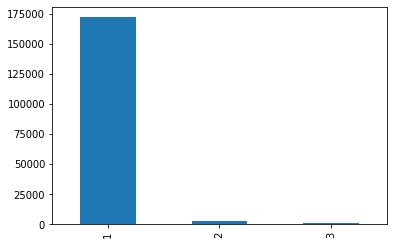

In [ ]:
xgb_scoret['label'].value_counts().plot.bar()

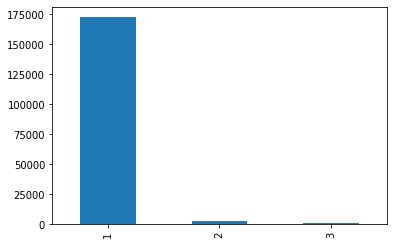

In [ ]:
lgb_scoret['label'].value_counts().plot.bar()

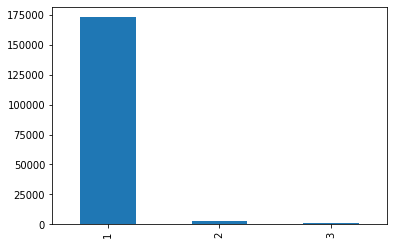

In [ ]:
cat_scoret['label'].value_counts().plot.bar()

In [ ]:
#用一个dataframe存储结果
result = pd.DataFrame()
#将三个模型的结果按照列排放，每个预测样本结果并列
pred = pd.concat([lgb_scoret,xgb_scoret,cat_scoret],axis=1)
#每一行取最大值
result['label'] = pred.max(axis=1)

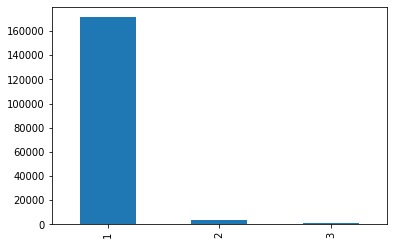

In [ ]:
#融合结果可视化
result['label'].value_counts().plot.bar()

In [ ]:
result['link']=testa['link']
result['current_slice_id']=testa['current_slice_id']
result['future_slice_id']=testa['future_slice_id']
result[['link','current_slice_id','future_slice_id','label']].to_csv('./drive/My Drive/datasets/data/submit.csv',index=False)